### Some util functions / model runners

### ResNet

Source: https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

In [61]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)


def ResNet34(num_classes):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)


def ResNet50(num_classes):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

# test()

### Imports

In [62]:
import torch
from torch.utils.data import DataLoader, random_split

from torchvision import datasets, transforms
from torchvision.models import AlexNet

import numpy as np

from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

(Comment in to use to clean cache)

In [63]:
#import gc

#gc.collect()

#torch.cuda.empty_cache()

### Load Images

Load from google drive

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Load the dataset and dataloader
We do this with a basic transformer, which only resizes the images.

In [97]:
#images_path = 'data/images'
#images_path = "/content/drive/MyDrive/Colab Notebooks/SeptemberHack/Bilder/all_resized_into_sub_folders_640"

# Images from Kaggle
# Source: https://www.kaggle.com/datasets/anshulmehtakaggl/chess-pieces-detection-images-dataset
images_path = "/content/drive/MyDrive/Colab Notebooks/SeptemberHack/Bilder/chess_pieces_2"

basic_transforms = transforms.Compose([
    transforms.Resize((32, 32)), # Transform so they go into the ResNet18 NN
    transforms.ToTensor(),
])

untransformed_dataset = datasets.ImageFolder(root=images_path, transform=basic_transforms)

### Function to get mean / std from images. Source:

Source: https://github.com/kuangliu/pytorch-cifar/blob/master/utils.py

In [98]:
def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

mean, std= get_mean_and_std(untransformed_dataset)
print(f"Untransformed images, mean is {mean}, std is {std}")

==> Computing mean and std..
Untransformed images, mean is tensor([0.6740, 0.6644, 0.6533]), std is tensor([0.2097, 0.2151, 0.2173])


#### Load dataset normalized with mean / std from above

In [99]:
enhanced_transforms = transforms.Compose([
    transforms.Resize((32, 32)), # Transform so they go into the ResNet18 NN
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std), # With the before calculated mean, std values.
])

# Dataset with the correctly transformed images
dataset = datasets.ImageFolder(root=images_path, transform=enhanced_transforms)

classes = dataset.classes
num_classes= len(dataset.classes)

In [100]:
print(f"Dataset has classes: {classes} (length: {num_classes}) Dataset length: is {len(dataset)}")

mean_updated, std_updated= get_mean_and_std(dataset)
print(f"Transformed images, mean is {mean_updated}, std is {std_updated}")

Dataset has classes: ['Queen-Resized', 'Rook-resize', 'bishop_resized', 'knight-resize', 'pawn_resized'] (length: 5) Dataset length: is 651
==> Computing mean and std..
Transformed images, mean is tensor([-8.5186e-07, -2.2011e-07, -8.6431e-08]), std is tensor([1.0000, 1.0000, 1.0000])


### Split Train and Test

We use 80 random images for our test (at the end), and 80 as validation.

In [121]:
num_samples = len(dataset)
indices = list(range(num_samples))
np.random.shuffle(indices)

# First 100 are Test data
test_split = 100
val_split = 200
train_idx, valid_idx, test_idx = indices[val_split:], indices[test_split:val_split], indices[:test_split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

In [122]:
print(f"train_idx: {len(train_idx)}, test_idx: {len(test_idx)}, valid_idx: {len(valid_idx)}")

train_idx: 451, test_idx: 100, valid_idx: 100


#### Create the dataloaders
We set a feasible batch size

In [123]:
batch_size = 20

train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size)
valid_loader = DataLoader(dataset, sampler=valid_sampler, batch_size=batch_size)
test_loader = DataLoader(dataset, sampler=test_sampler, batch_size=batch_size)

### Plot images

In [124]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

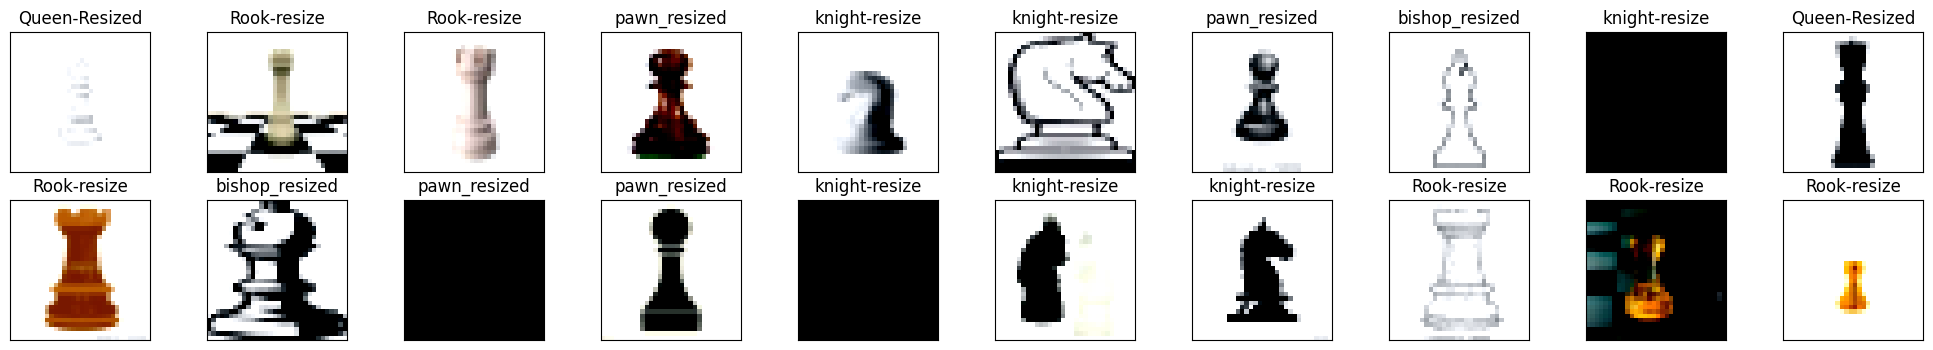

In [125]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### Test for CUDA

Make sure to install the correct CUDA version and packages, see: https://pytorch.org/get-started/locally/

In [129]:
# check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

Using cuda


### Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

In [132]:
# Define the network: ResNet101
net = ResNet50(num_classes)
net.to(device)

# specify loss function
criterion = torch.nn.CrossEntropyLoss()

# Optimizer and momentum
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

model = net
train_on_gpu = torch.cuda.is_available()

print(train_on_gpu)

True


In [133]:
# number of epochs to train the model
n_epochs = 30 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    ######################
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.586927 	Validation Loss: 0.238497
Validation loss decreased (inf --> 0.238497).  Saving model ...
Epoch: 2 	Training Loss: 1.184317 	Validation Loss: 0.236995
Validation loss decreased (0.238497 --> 0.236995).  Saving model ...
Epoch: 3 	Training Loss: 1.180165 	Validation Loss: 0.593776
Epoch: 4 	Training Loss: 1.167531 	Validation Loss: 0.259012
Epoch: 5 	Training Loss: 1.248824 	Validation Loss: 7.079423
Epoch: 6 	Training Loss: 1.197667 	Validation Loss: 0.256119
Epoch: 7 	Training Loss: 1.168380 	Validation Loss: 0.239784
Epoch: 8 	Training Loss: 1.110708 	Validation Loss: 0.294206
Epoch: 9 	Training Loss: 1.116678 	Validation Loss: 0.233962
Validation loss decreased (0.236995 --> 0.233962).  Saving model ...
Epoch: 10 	Training Loss: 1.115702 	Validation Loss: 0.248061
Epoch: 11 	Training Loss: 1.030789 	Validation Loss: 0.235562
Epoch: 12 	Training Loss: 0.949632 	Validation Loss: 0.261063
Epoch: 13 	Training Loss: 0.979445 	Validation Loss: 1.430568
E

###  Load the Model with the Lowest Validation Loss


In [134]:
model.load_state_dict(torch.load('model_cifar.pt'))


<All keys matched successfully>

---
## Test the Trained Network

Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [135]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(num_classes):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.189405

Test Accuracy of Queen-Resized: 10% ( 2/19)
Test Accuracy of Rook-resize: 40% ( 9/22)
Test Accuracy of bishop_resized: 61% (13/21)
Test Accuracy of knight-resize: 62% (17/27)
Test Accuracy of pawn_resized: 54% ( 6/11)

Test Accuracy (Overall): 47% (47/100)


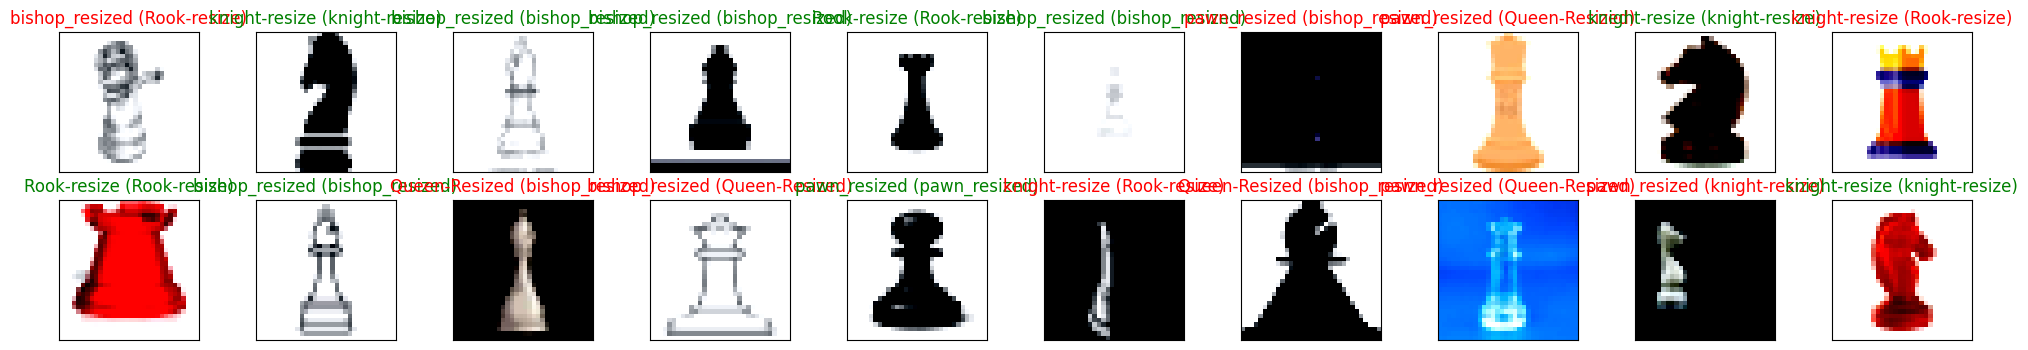

In [136]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))